# Replicated Logs Performance Metrics Analysis

We are given benchmarks on replicated logs performance.  
The goal is to identify outliers (like a sudden drop or increase in performance). This can be accomplished using some variant of Z-score.  
In order to further identify structural breaks, we use the Chow Test.

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f

In [2]:
plt.rcParams["figure.figsize"] = (16,9)

In [3]:
%matplotlib notebook

## Loading data

8 types of benchmarks are scheduled every day.  
- insert-c1-r3-wc1
- insert-c1-r3-wc1-ws
- insert-c1-r3-wc2
- insert-c1-r3-wc2-ws
- insert-c10-r3-wc2
- insert-c10-r3-wc2-ws
- insert-c100-r3-wc2
- insert-c100-r3-wc2-ws
  
We get last 50 days.  

In [4]:
data = json.load(open('replicated_logs_perf_results.json'))

In [5]:
names = [b['name'] for b in data if not b['name'].endswith('ws')]

In [6]:
def create_dataframe(data):
    return pd.DataFrame.from_records([
        {
            'name': bench['name'],
            'date': res['date'],
            'norm_date': norm_date,
            'min': res['values']['min'],
            'max': res['values']['max'],
            'p99': res['values']['p99'],
            'p99.9': res['values']['p99.9'],
            'avg': res['values']['avg'],
            'rps': res['values']['rps'],
            'total': res['values']['total'],
            'json': json.dumps(bench, separators=(',', ':'))
        }
        for bench in data for norm_date, res in enumerate(sorted(bench['latest_results'], key=lambda x: x['date']))
    ])

In [7]:
df = create_dataframe(data)

In [8]:
df.head()

,name,date,norm_date,min,max,p99,p99.9,avg,rps,total,json
0,insert-c1-r3-wc1,1636989774,0,0.000398,0.002135,0.000870,0.001840,0.000675,1480.233464,6.755691,"{""name"":""insert-c1-r3-wc1"",""latest_results"":[{..."
1,insert-c1-r3-wc1,1637073471,1,0.000316,0.002524,0.000957,0.001953,0.000694,1440.831852,6.940435,"{""name"":""insert-c1-r3-wc1"",""latest_results"":[{..."
2,insert-c1-r3-wc1,1637159694,2,0.000319,0.008033,0.000957,0.002008,0.000706,1415.481056,7.064736,"{""name"":""insert-c1-r3-wc1"",""latest_results"":[{..."
3,insert-c1-r3-wc1,1637246361,3,0.000264,0.002559,0.000777,0.001688,0.000518,1929.661174,5.182257,"{""name"":""insert-c1-r3-wc1"",""latest_results"":[{..."
4,insert-c1-r3-wc1,1637422554,4,0.000344,0.004220,0.000951,0.002039,0.000675,1479.628002,6.758455,"{""name"":""insert-c1-r3-wc1"",""latest_results"":[{..."


## Analysis
This section gives an overview of the data. We'll take a look at each variable.

In [9]:
def plot_reg(parameter):
    sns.set(font_scale=0.5)
    fig, axis = plt.subplots(4, 2, dpi=140, sharex=True)
    for row, name in enumerate(names):
        ylabel = parameter if row == 0 else None
        xlabel = 'days in ascending order' if row == len(names) - 1 else None
        ws = f'{name}-ws'
        axis[row, 0].set_title(name)
        axis[row, 1].set_title(ws)
        sns.regplot(x='norm_date', y=parameter, data=df[df['name'] == name], ax=axis[row, 0]).set(xlabel=xlabel, ylabel=ylabel)
        sns.regplot(x='norm_date', y=parameter, data=df[df['name'] == ws], ax=axis[row, 1]).set(xlabel=None, ylabel=None)

In [10]:
def plot_cat(parameter):
    sns.set(font_scale=0.5)
    sns.catplot(data=df, kind='bar', x='name', y=parameter,ci="sd", palette="dark", alpha=.6, height=6)

### rsp

Remark: insert-c10-r3-wc2-ws

<IPython.core.display.Javascript object>


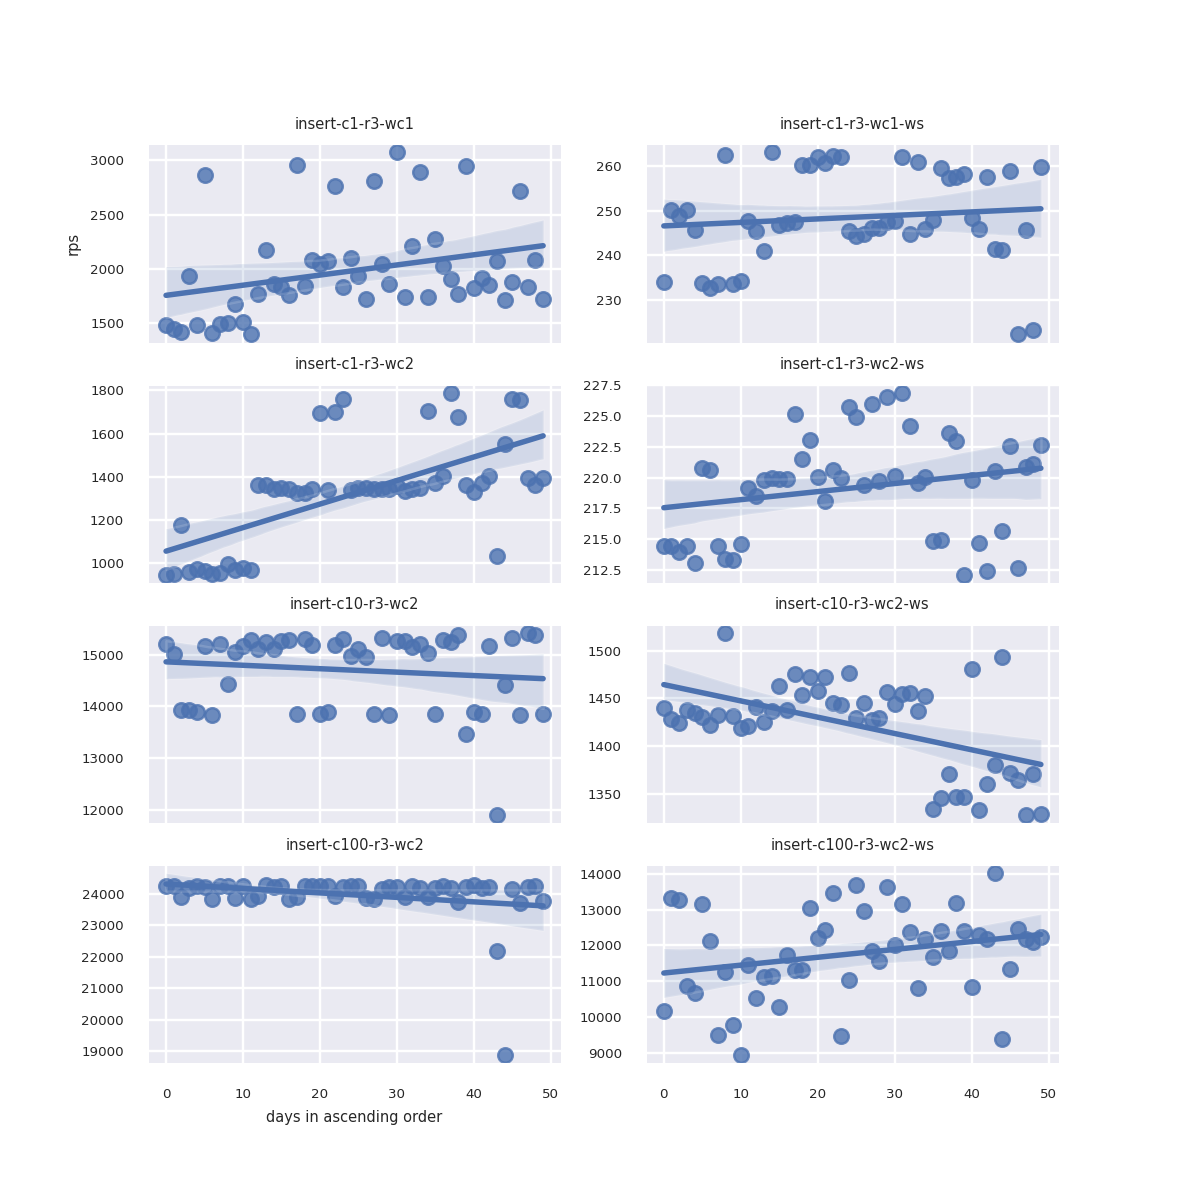

In [11]:
plot_reg('rps')

<IPython.core.display.Javascript object>


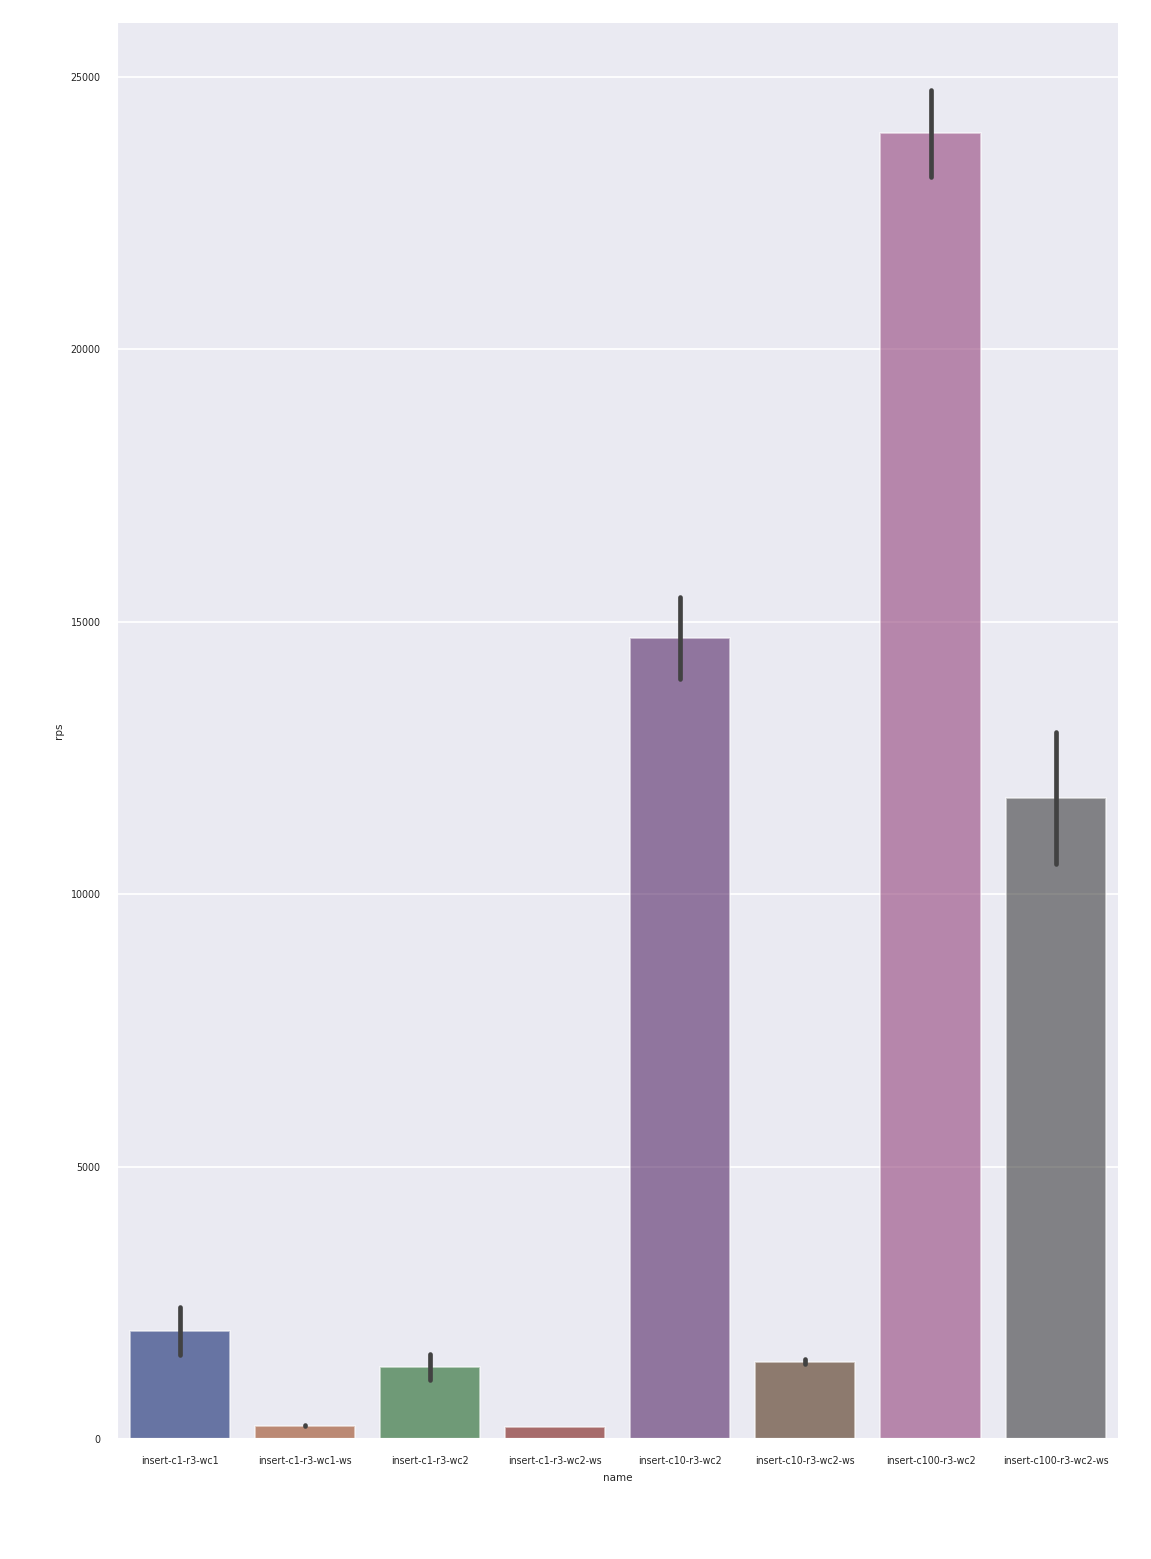

In [12]:
plot_cat('rps')

### total

<IPython.core.display.Javascript object>


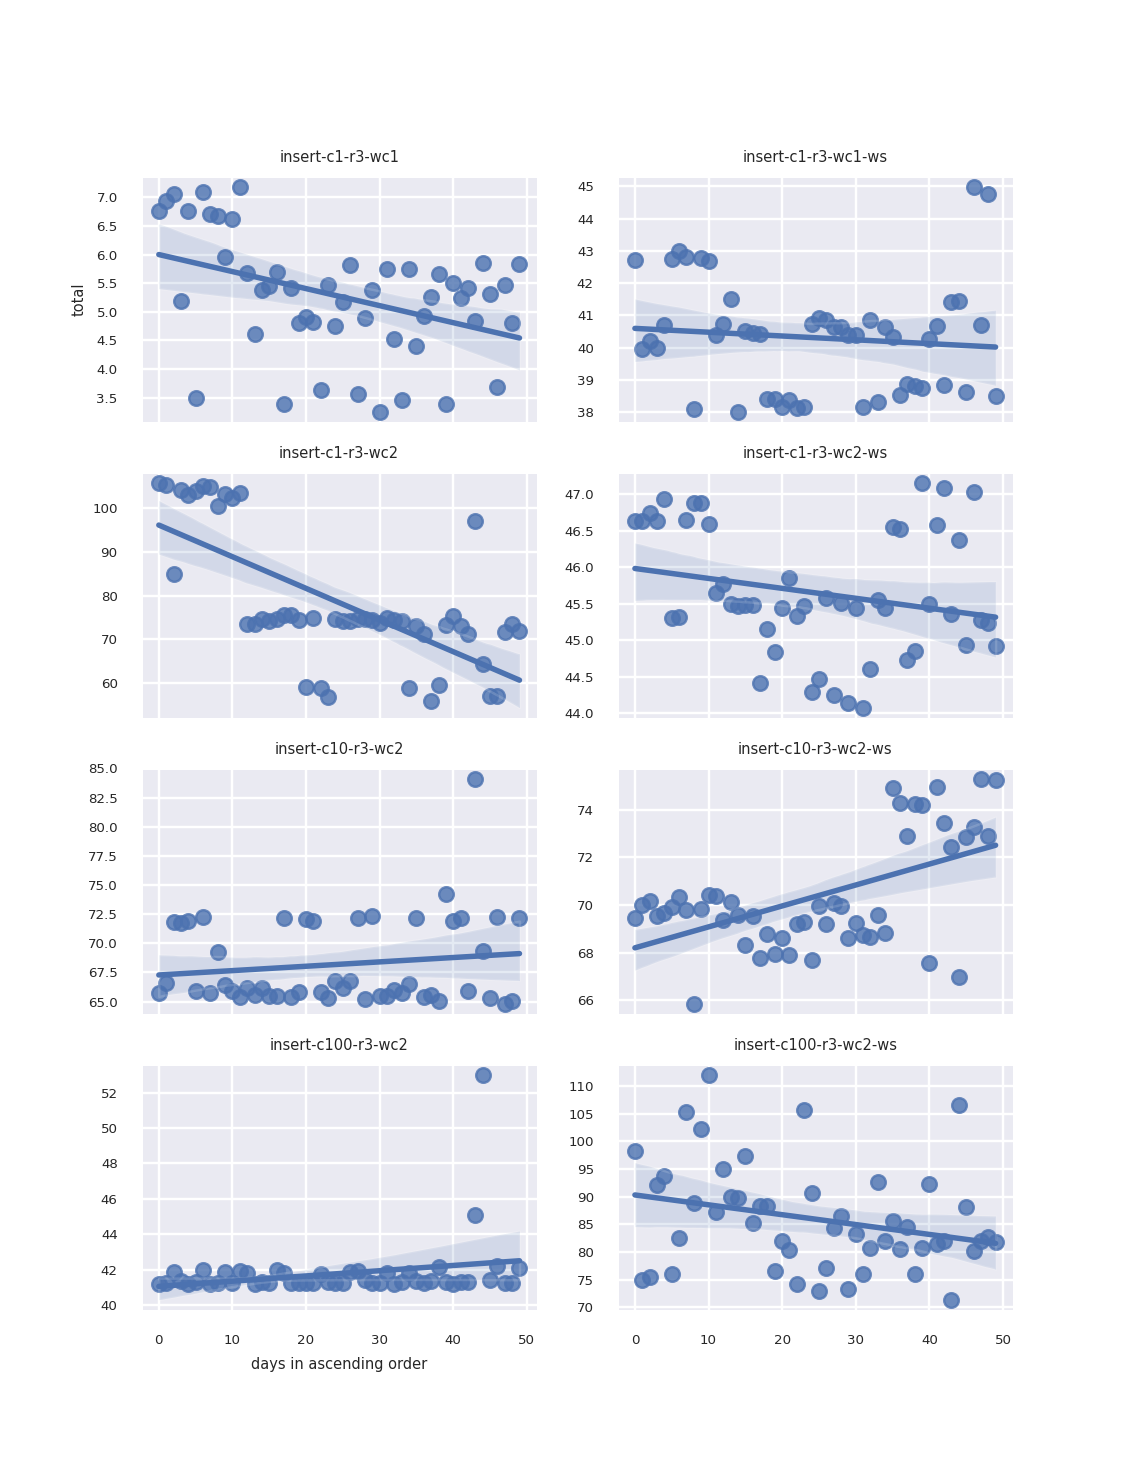

In [13]:
plot_reg('total')

### avg

<IPython.core.display.Javascript object>


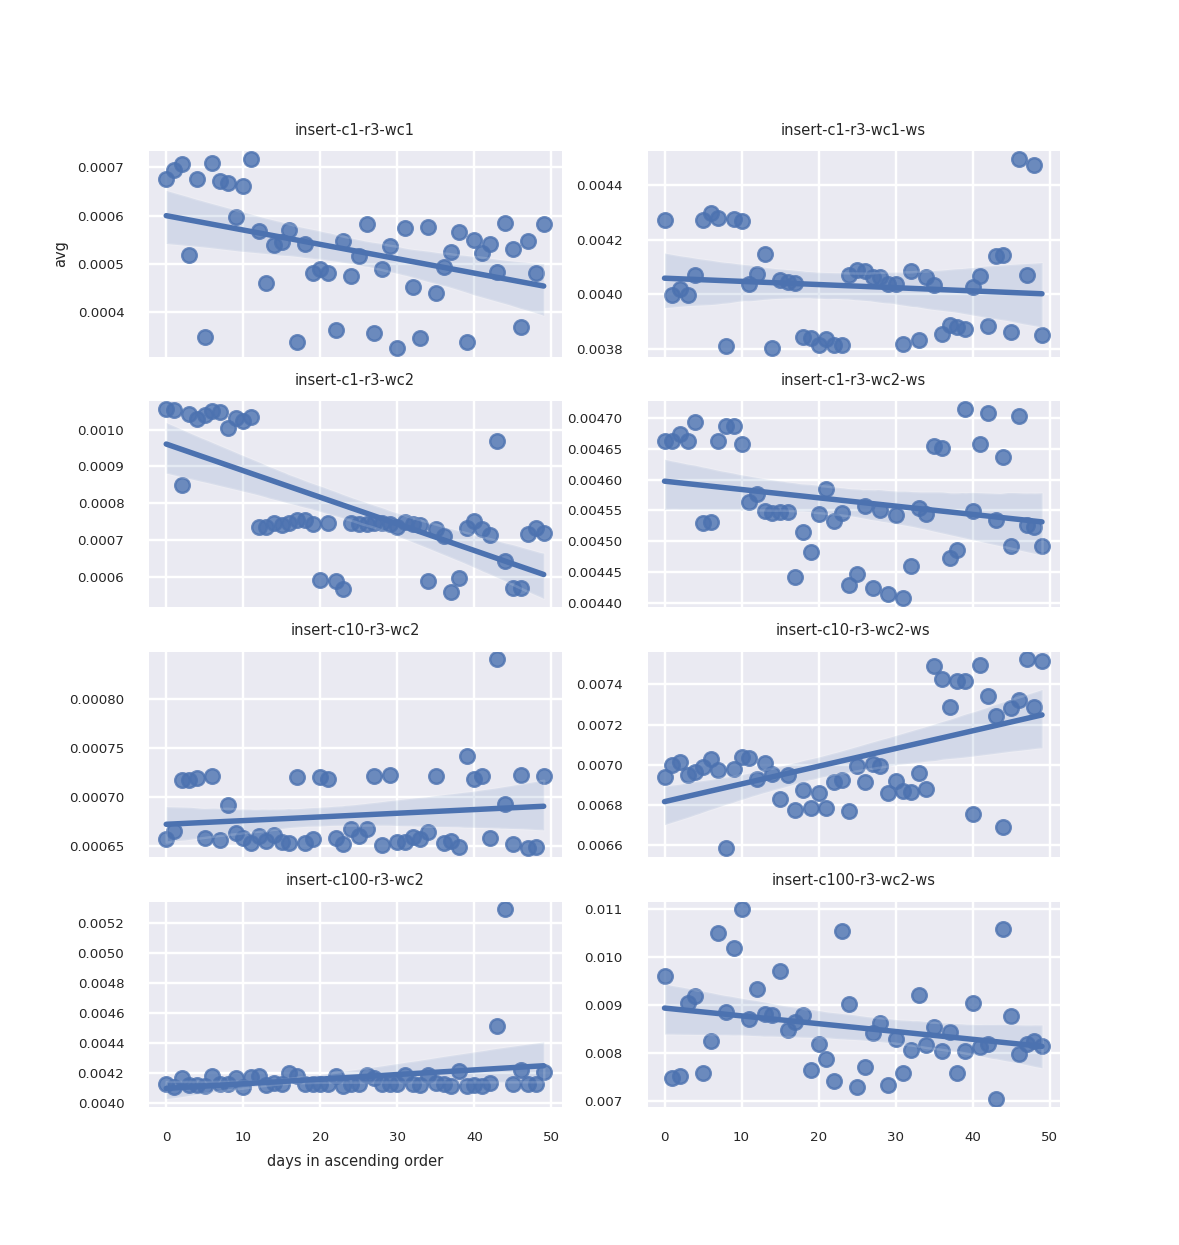

In [14]:
plot_reg('avg')

### Try out

In [15]:
#plot_reg('max')

## Outlier detection

During experiments we are going to treat the most recent set of benchmarks as the one to be analyzed, while the previous 49 are used as training set.

In [16]:
def is_outlier(value, threshold):
    return np.abs(value) > threshold

In [17]:
def plot_outliers(scorer, x, y, threshold):
    y = scorer.transform(y)
    mask = is_outlier(y, threshold)

    plt.figure(dpi=140)
    plt.plot(x[~mask], y[~mask],'o', color='b',label='normal')
    plt.plot(x[mask], y[mask],'o', color='r', label='unusual')
    plt.axhline(0, color='black', alpha=0.5, label='mean')
    plt.axhline(-threshold, color='r', alpha=0.5)
    plt.axhline(threshold, color='r', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Outlier detection', fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Anomaly score')
    plt.show()

### Z-score

Shows how many standard deviations away are data-points from the mean.

In [18]:
class ZScore:
    def __init__(self):
        self._mean = 0  # mean
        self._std = 1   # standard deviation
    
    def fit(self, x):
        self._mean = np.mean(x)
        self._std = np.std(x)
    
    def transform(self, x):
        return (x - self._mean) / self._std

Train a simple scorer on the first 49 days

In [19]:
last_entry = 49
benchmark = 'insert-c10-r3-wc2-ws'
parameter = 'total'
scorer = ZScore()
scorer.fit(df[df['name'] == benchmark][parameter][:last_entry])

Check if last day's result is an outlier

In [21]:
is_outlier(scorer.transform(df[df['name'] == benchmark][parameter][last_entry:].values[0]), threshold=2)

True

Check if there are other outliers present

<IPython.core.display.Javascript object>


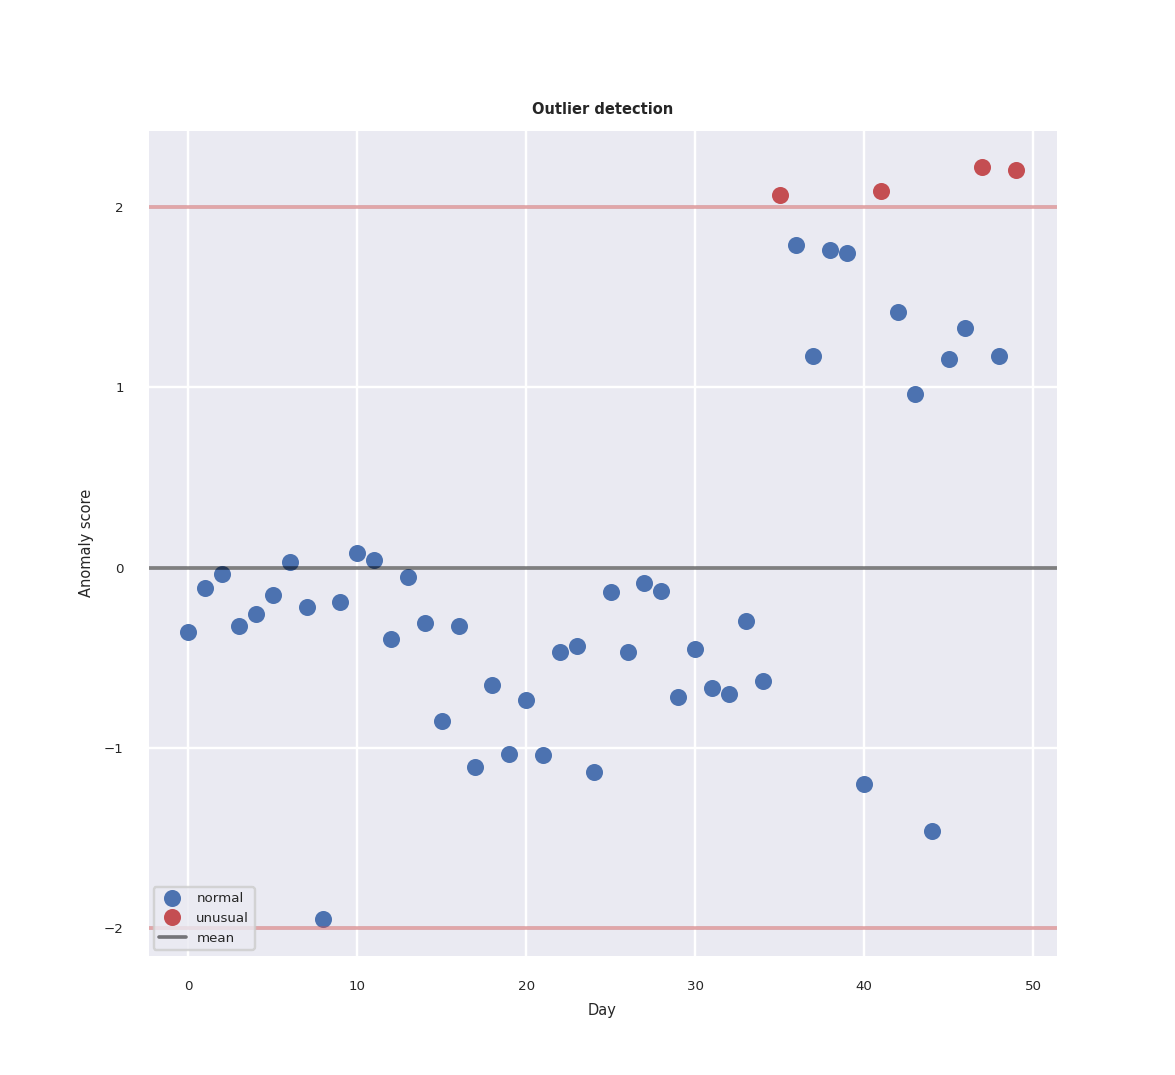

In [22]:
plot_outliers(scorer, df[df['name'] == benchmark]['norm_date'], df[df['name'] == benchmark][parameter], threshold=2)

### Modified Z-score
This has the potential to work better on small datasets, because it is a bit more robust in case of outliers.

In [23]:
class ModifiedZScore:
    def __init__(self):
        self._k = 0.6745  # constant, assuming a normal distribution
        self._median = 0  # median
        self._mda = 1     # median of absolute deviations
    
    def fit(self, x):
        self._median = np.median(x)
        self._mda = np.median(np.abs(x - self._median))
        
    def transform(self, x):
        return self._k * (x - self._median) / self._mda

In [24]:
last_entry = 49
benchmark = 'insert-c10-r3-wc2-ws'
parameter = 'total'
scorer = ModifiedZScore()
scorer.fit(df[df['name'] == benchmark][parameter][:last_entry])

In [25]:
is_outlier(scorer.transform(df[df['name'] == benchmark][parameter][last_entry:].values[0]), threshold=3.5)

True

<IPython.core.display.Javascript object>


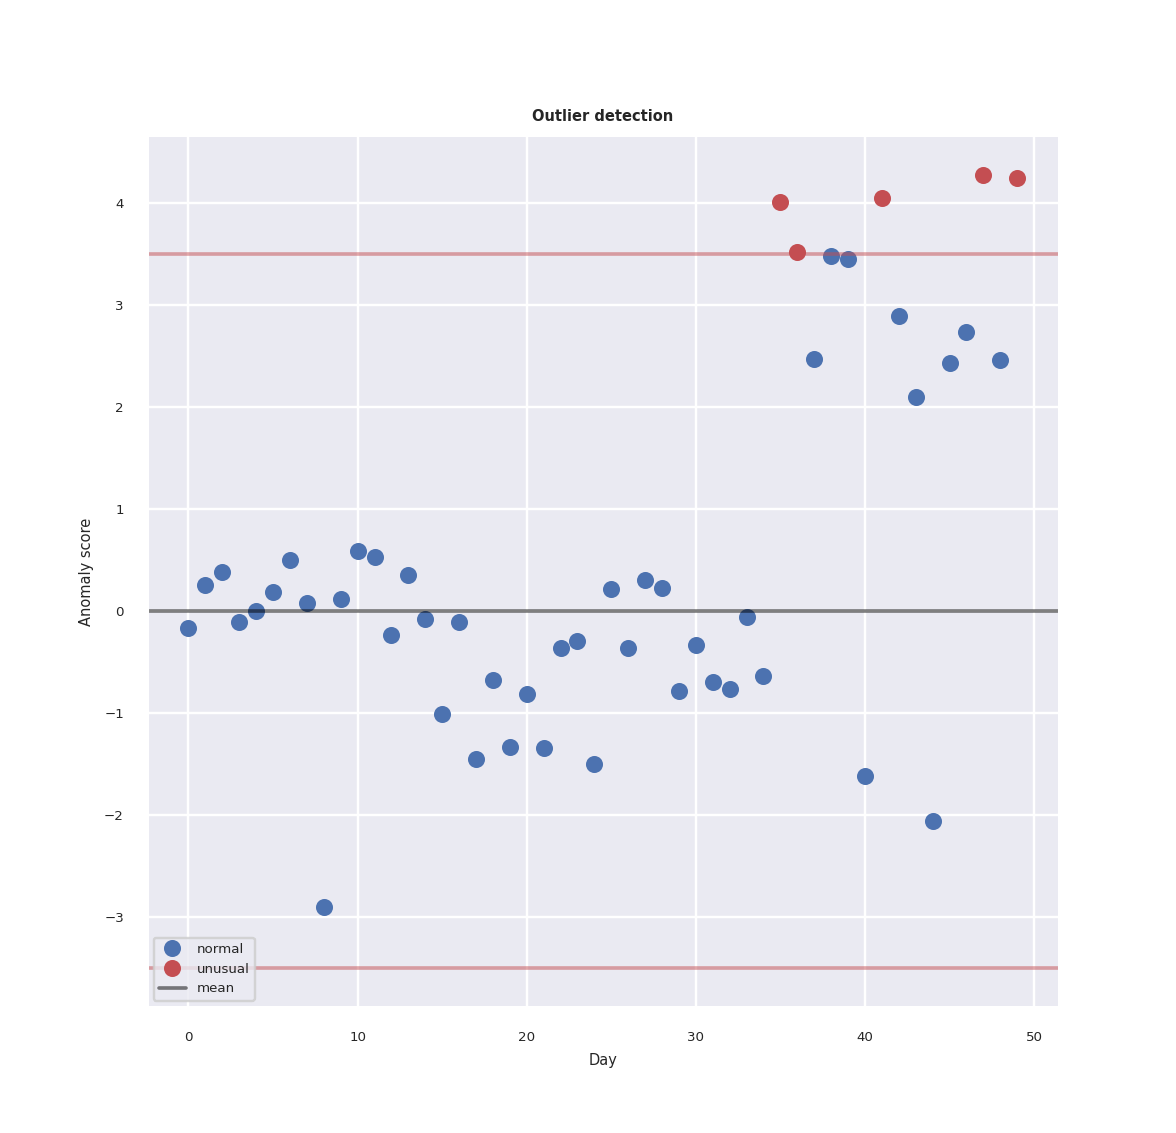

In [26]:
plot_outliers(scorer, df[df['name'] == benchmark]['norm_date'], df[df['name'] == benchmark][parameter], threshold=3.5)

## Structural breaks

At some point there might be a structural break in our dataset. Using the Chow Test,
we can pinpoint a date and check if a structural break occured on that day.

Suppose we are analyzing the past 50 days and choose day 25 for the structural break test. The Chow Test works by splitting the dataset into two:
- before: days 0..25, before the break
- after: days 26..49, after the break
  
We run a regression on the `entire` dataset, one on `before` and another on `after`.  
We apply the [formula](https://www.statisticshowto.com/chow-test/), in our case with `k=2` because we have two degress of freedom (the dataset has two columns, day and value).
  
We then apply the [F test](http://www.socr.ucla.edu/Applets.dir/F_Table.html) the the Chow result, choosing an alpha value that would best fit our needs.
  
The way I think about the result (which might not be 100% accurate explanation), is this:
- an alpha of 0.01 indicates 99% confidence
- if chow > F(alpha, dfn, dfd) I'll say that the Chow Test is 99% confident that it found a structural break
- use lower values of alpha to decrease false positives

In [27]:
def chow_test(x, y, day, alpha=0.000005, k=2):
    dfn = k
    dfd = len(x) - 2 * k
    res = sm.OLS(y, x).fit()
    ssr_total = res.ssr
    res = sm.OLS(y[:day], x[:day]).fit()
    ssr_before = res.ssr
    res = sm.OLS(y[day + 1:], x[day + 1:]).fit()
    ssr_after = res.ssr
    numerator = (ssr_total - (ssr_before + ssr_after)) / dfn
    denominator = (ssr_before + ssr_after) / dfd
    chow = numerator / denominator
    return chow > f.ppf(q=1-alpha, dfn=dfn, dfd=dfd)

### Visualize possible days when a structural break occurred

In [28]:
def plot_breaks(x, y):
    mask = np.array([False] + [chow_test(x, y, i) for i in range(1, len(x) - 1)] + [False])
    plt.figure(dpi=140)
    plt.plot(x[~mask], y[~mask],'o', color='b',label='normal')
    plt.plot(x[mask], y[mask],'o', color='r', label='break')
    plt.title('Structural breaking points', fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Benchmark Result')
    plt.show()

In [29]:
benchmark = 'insert-c10-r3-wc2-ws'
parameter = 'total'
x = df[df['name'] == benchmark]['norm_date'].values
y = df[df['name'] == benchmark][parameter].values

In [30]:
print([chow_test(x, y, i) for i in range(1, len(x) - 1)])

[False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


<IPython.core.display.Javascript object>


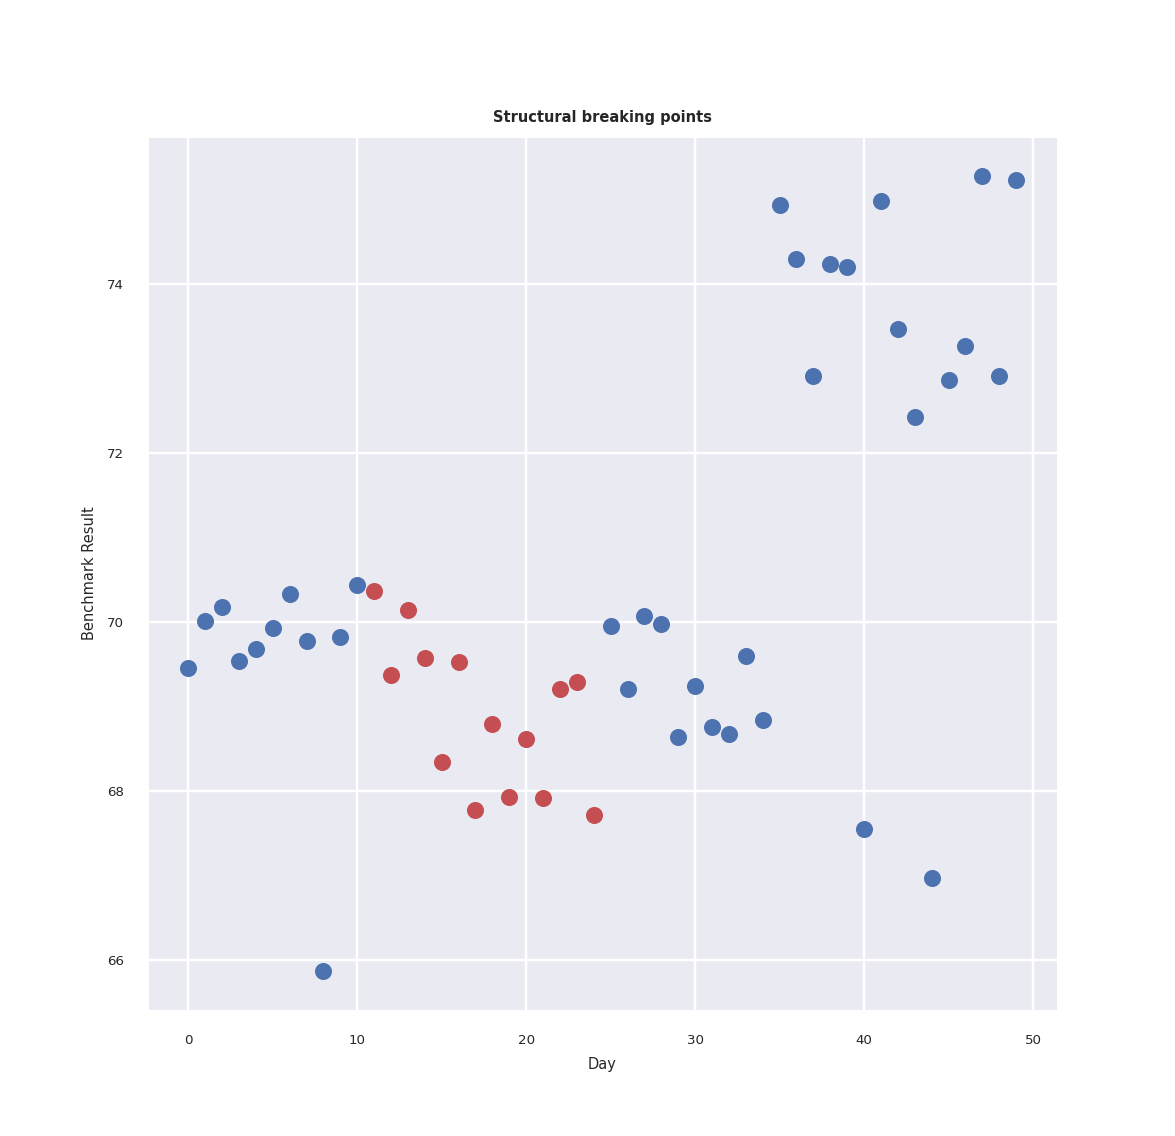

In [31]:
plot_breaks(x, y)

### Visualize how the Chow test would look for at day

In [32]:
def visualize_chow(x, y, day):
    fig, ax = plt.subplots()
    sns.regplot(x=x, y=y, ax=ax, color='black', scatter=False)
    sns.regplot(x=x[:day], y=y[:day], ax=ax, color='red', scatter=True)
    sns.regplot(x=x[day + 1:], y=y[day + 1:], ax=ax, color='blue', scatter=True)
    plt.title('Chow Test Regressions', fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Benchmark Result')

<IPython.core.display.Javascript object>


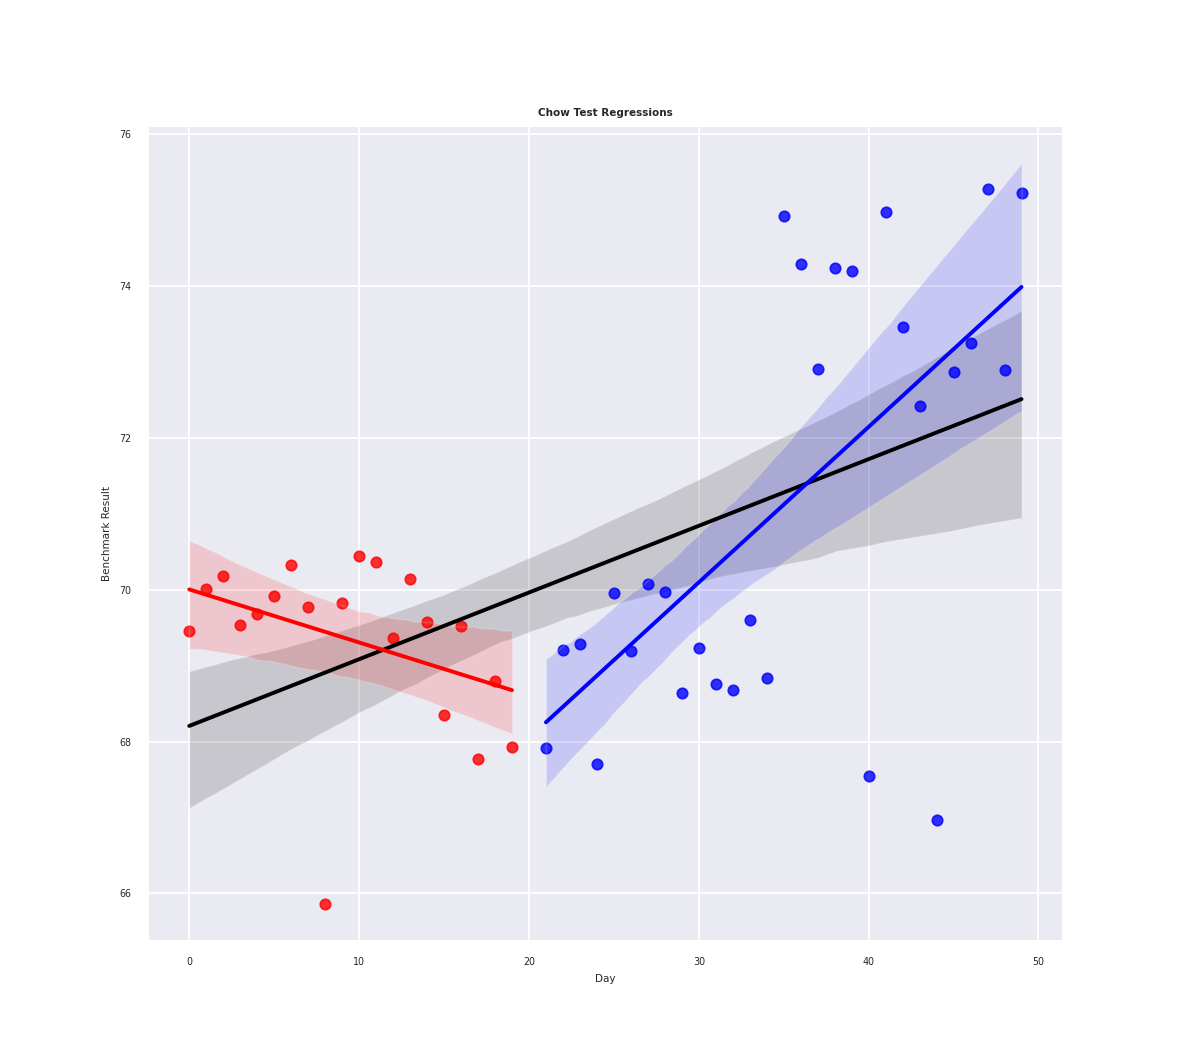

In [33]:
visualize_chow(x, y, 20)

So there's definitely a structural break at day 20. Let's see how early could we have discovered it.

In [34]:
day_of_discovery = []
for days in range(22, len(x)):
    if chow_test(x[:days], y[:days], 20):
        day_of_discovery.append(days)
day_of_discovery

[46, 47, 48, 49]

It turns out that the earliest we could have discovered the structural break is at day 46.